In [4]:
from captum.attr import IntegratedGradients
# ==== 1) load packages ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import random
os.chdir(
    # "/home/yliu420/Project/Belief-Elicitation-on-LLM-postrelease/analysis"
    "/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis"
)
from analysis_pkg.preprocess import *
from analysis_pkg.models import *
from analysis_pkg.adptive_lasso import *
torch.manual_seed(2025)
random.seed(2025)

In [3]:
def individual_IG_real_profiles(model, df, x_mean_single=None):
    import torch
    import matplotlib.pyplot as plt
    from captum.attr import IntegratedGradients

    # =========================
    # 1. 预处理输入
    # =========================
    X_df = preprocess_test(df.iloc[:, :10])
    feature_names = [i.split(" (")[0] for i in df.columns.tolist()[:10]]

    x = X_df.clone().detach().requires_grad_(True)

    if x_mean_single is None:
        x_mean = torch.zeros_like(x)
    else:
        x_mean = x_mean_single.tile(x.shape[0], 1)

    # =========================
    # 2. Integrated Gradients
    # =========================
    ig = IntegratedGradients(model)
    attributions = ig.attribute(
        x,
        target=None,
        baselines=x_mean,
        n_steps=100
    )

    print("Attribution shape:", attributions.shape)  # (8, 10)

    attrs = attributions.detach().cpu().numpy()

    # =========================
    # 3. 绘图（透明背景）
    # =========================
    fig, axes = plt.subplots(4, 2, figsize=(14, 12))

    # ✅ 整个画布透明
    fig.patch.set_alpha(0)

    axes = axes.flatten()

    for i in range(8):
        attr_i = attrs[i]

        # 横向柱状图
        axes[i].barh(range(len(attr_i)), attr_i)

        axes[i].set_title(df.index[i])
        axes[i].set_xlabel("Attribution Value")

        if i % 2 == 0:
            axes[i].set_yticks(range(len(attr_i)))
            axes[i].set_yticklabels(feature_names)
        else:
            axes[i].set_yticks([])
            axes[i].set_yticklabels([])

        # ✅ 子图背景也透明（双保险）
        axes[i].set_facecolor("none")

    plt.tight_layout()

    # =========================
    # 4. 透明背景保存
    # =========================
    plt.savefig(
        f"../plot/{model.__class__.__name__}_IG_individual_real_profiles.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True
    )

    plt.show()

In [27]:
def individual_IG_real_profiles(model, df, x_mean_single=None):
    import torch
    import matplotlib.pyplot as plt
    from captum.attr import IntegratedGradients

    # =========================
    # 1. 预处理输入 (保持不变)
    # =========================
    X_df = preprocess_test(df.iloc[:, :10])
    feature_names = [i.split(" (")[0] for i in df.columns.tolist()[:10]]

    x = X_df.clone().detach().requires_grad_(True)

    if x_mean_single is None:
        x_mean = torch.zeros_like(x)
    else:
        x_mean = x_mean_single.tile(x.shape[0], 1)

    # =========================
    # 2. Integrated Gradients
    # =========================
    ig = IntegratedGradients(model)
    attributions = ig.attribute(
        x,
        target=None,
        baselines=x_mean,
        n_steps=100
    )
    
    attrs = attributions.detach().cpu().numpy()

    # =========================
    # 3. 绘图（只画后4个）
    # =========================
    # ⬆️ 调整：稍微加大画布尺寸，防止大字号拥挤
    fig, axes = plt.subplots(2, 2, figsize=(16, 8)) 

    # ✅ 整个画布透明
    fig.patch.set_alpha(0)

    axes = axes.flatten()

    target_indices = range(4, 8) 

    for plot_idx, data_idx in enumerate(target_indices):
        attr_i = attrs[data_idx]

        # --- 颜色逻辑 (严格保留你的修改) ---
        bar_colors = ['#1f77b4'] * len(attr_i)

        if data_idx == 5:
            # 严格保留你的 index 设置：2 和 6
            if len(attr_i) > 2:
                bar_colors[2] = '#EB811B' 
            if len(attr_i) > 6:
                bar_colors[6] = '#EB811B' 

        # --- 绘图 ---
        axes[plot_idx].barh(range(len(attr_i)), attr_i, color=bar_colors)

        # ⬆️ 调整：标题字号加大，加粗
        axes[plot_idx].set_title(df.index[data_idx], fontsize=16, fontweight='bold')
        
        # ⬆️ 调整：X轴标签字号加大
        # axes[plot_idx].set_xlabel("Attribution Value", fontsize=16)
        
        # ⬆️ 调整：刻度数字字号加大
        axes[plot_idx].tick_params(axis='both', which='major', labelsize=14)

        # --- 坐标轴标签逻辑 ---
        if plot_idx % 2 == 0:
            axes[plot_idx].set_yticks(range(len(attr_i)))
            # ⬆️ 调整：Y轴特征名 (Feature Names) 字号加大
            axes[plot_idx].set_yticklabels(feature_names, fontsize=14)
        else:
            axes[plot_idx].set_yticks([])
            axes[plot_idx].set_yticklabels([])

        # ✅ 子图背景透明
        axes[plot_idx].set_facecolor("none")

    plt.tight_layout()

    # =========================
    # 4. 保存
    # =========================
    plt.savefig(
        f"../plot/{model.__class__.__name__}_IG_individual_real_profiles_last4.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True
    )

    plt.show()

# Prepare data

In [6]:
# ==== 2) load training data ====
processes = 10
## load profiles and LLM expectations to profiles and df
fl = [f"../output/{i*1000}_{(i+1)*1000}.csv" for i in range(processes)]
# combine all csv files
df = pd.concat([pd.read_csv(f) for f in fl])
profiles = pd.read_csv("../data/profiles_shuffled.csv")

In [7]:
# ==== 3) preprocess training data ====
## split to Xi and Xj by odd and even rows
X = preprocess(profiles[:2000*processes])
Xi = X[0:2000*processes:2]
Xj = X[1:2000*processes:2]
y = df["profile_id"].apply(lambda x: 1 if x % 2 == 0 else -1)
y = torch.from_numpy(y.values).float()
P, d = Xi.shape

In [8]:
# ==== 4) train model, and calibration ====
split = int(0.9 * P)
ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)

In [9]:
# ==== randomly sample 1000 profiles as validation set ====
test_indices = random.sample(range(profiles.shape[0]), 1000)
profiles_val = profiles.iloc[test_indices].reset_index(drop=True)
# set dtype of column 8 to float64
profiles_val['RAM'] = profiles_val['RAM'].astype('float64')
## preprocess all profiles
X_val = preprocess_test(profiles_val.iloc[:,:10])
features = profiles_val.columns.tolist()[:10]
X_val_df = pd.DataFrame(X_val, columns=features)

In [10]:
real_profiles = pd.read_csv("../data/real_profiles.csv")
real_profiles.set_index('real model', inplace=True)

# MLP: IG for iPhone 16 and 17 lineup

In [9]:
## score all profiles
torch.manual_seed(2025)
model_mlp = MLPScorer(d_in=d, hidden=(256, 128), dropout=0.1)
model_mlp = train_pairwise(model_mlp, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)
model_mlp.eval()

[Epoch 01] train_loss=0.4667  val_loss=0.4095
[Epoch 02] train_loss=0.4036  val_loss=0.4027
[Epoch 03] train_loss=0.3936  val_loss=0.3982
[Epoch 04] train_loss=0.3827  val_loss=0.3912
[Epoch 05] train_loss=0.3818  val_loss=0.3979
[Epoch 06] train_loss=0.3726  val_loss=0.3891
[Epoch 07] train_loss=0.3697  val_loss=0.3908
[Epoch 08] train_loss=0.3664  val_loss=0.3993


MLPScorer(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Attribution shape: torch.Size([8, 10])


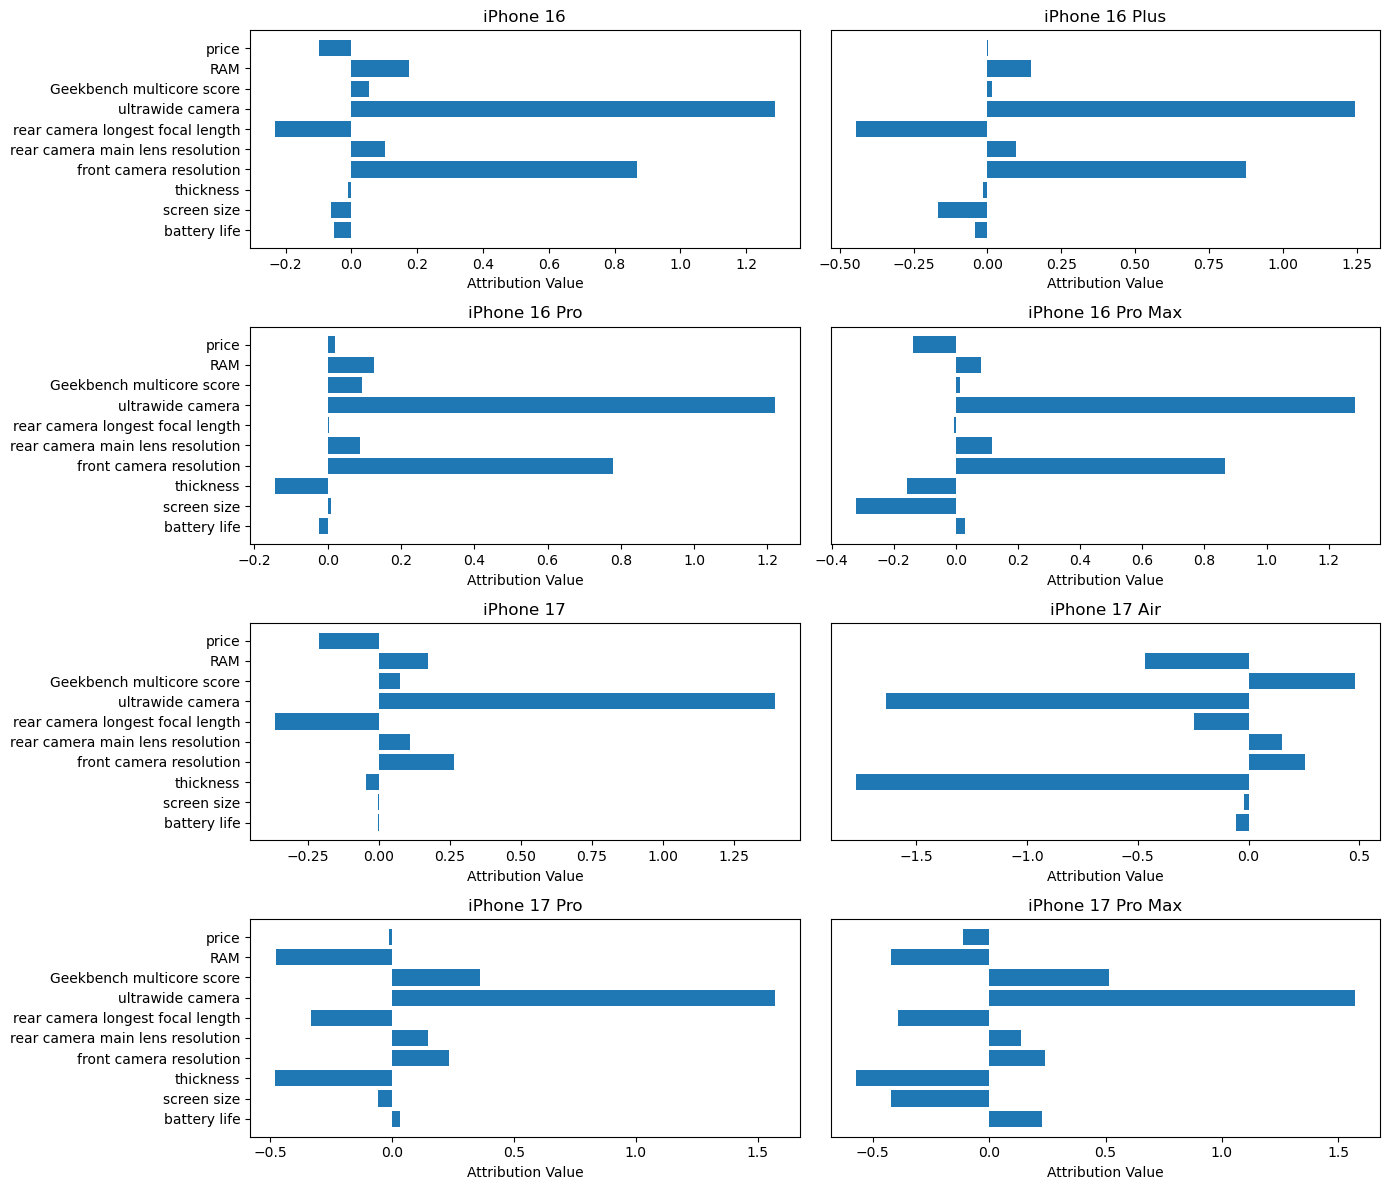

In [10]:
x_mean_single = X_val.mean(dim=0)
individual_IG_real_profiles(model_mlp, real_profiles, x_mean_single=x_mean_single)

# MLP_Attention

In [24]:
# ==== MLP Attention ====
model_att = MLPAttentionScore(d_in=d, hidden=(256, 128), dropout=0.1, n_heads=2)
model_att = train_pairwise(model_att, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

[Epoch 01] train_loss=0.4516  val_loss=0.4133
[Epoch 02] train_loss=0.3719  val_loss=0.3717
[Epoch 03] train_loss=0.3590  val_loss=0.3742
[Epoch 04] train_loss=0.3544  val_loss=0.3759
[Epoch 05] train_loss=0.3497  val_loss=0.3687
[Epoch 06] train_loss=0.3509  val_loss=0.3748
[Epoch 07] train_loss=0.3477  val_loss=0.3656
[Epoch 08] train_loss=0.3476  val_loss=0.3666
[Epoch 09] train_loss=0.3458  val_loss=0.3658


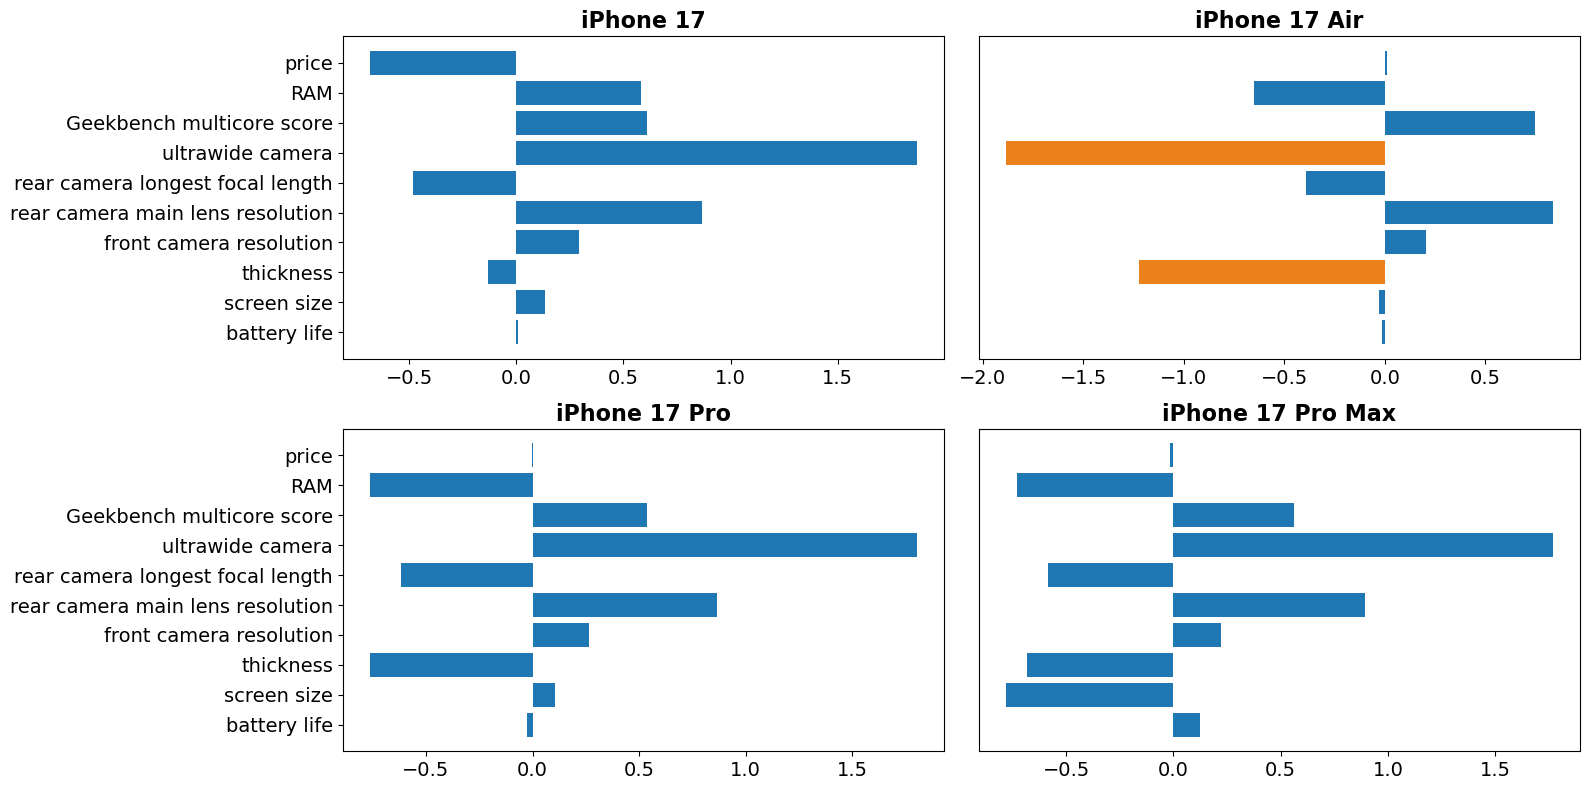

In [28]:
x_mean_single = X_val.mean(dim=0)
individual_IG_real_profiles(model_att, real_profiles, x_mean_single=x_mean_single)

# Logistic Regression

In [13]:
torch.manual_seed(2025)
model_lr = LogisticRegression(d_in=d)
model_lr = train_pairwise(model_lr, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

[Epoch 01] train_loss=0.6710  val_loss=0.6235
[Epoch 02] train_loss=0.6055  val_loss=0.5807
[Epoch 03] train_loss=0.5669  val_loss=0.5554
[Epoch 04] train_loss=0.5423  val_loss=0.5383
[Epoch 05] train_loss=0.5248  val_loss=0.5255
[Epoch 06] train_loss=0.5112  val_loss=0.5144
[Epoch 07] train_loss=0.5001  val_loss=0.5054
[Epoch 08] train_loss=0.4908  val_loss=0.4973
[Epoch 09] train_loss=0.4826  val_loss=0.4904
[Epoch 10] train_loss=0.4757  val_loss=0.4843
[Epoch 11] train_loss=0.4697  val_loss=0.4791
[Epoch 12] train_loss=0.4645  val_loss=0.4743
[Epoch 13] train_loss=0.4600  val_loss=0.4706
[Epoch 14] train_loss=0.4561  val_loss=0.4673
[Epoch 15] train_loss=0.4527  val_loss=0.4644
[Epoch 16] train_loss=0.4497  val_loss=0.4618
[Epoch 17] train_loss=0.4471  val_loss=0.4597
[Epoch 18] train_loss=0.4450  val_loss=0.4578
[Epoch 19] train_loss=0.4431  val_loss=0.4564
[Epoch 20] train_loss=0.4415  val_loss=0.4551


Attribution shape: torch.Size([8, 10])


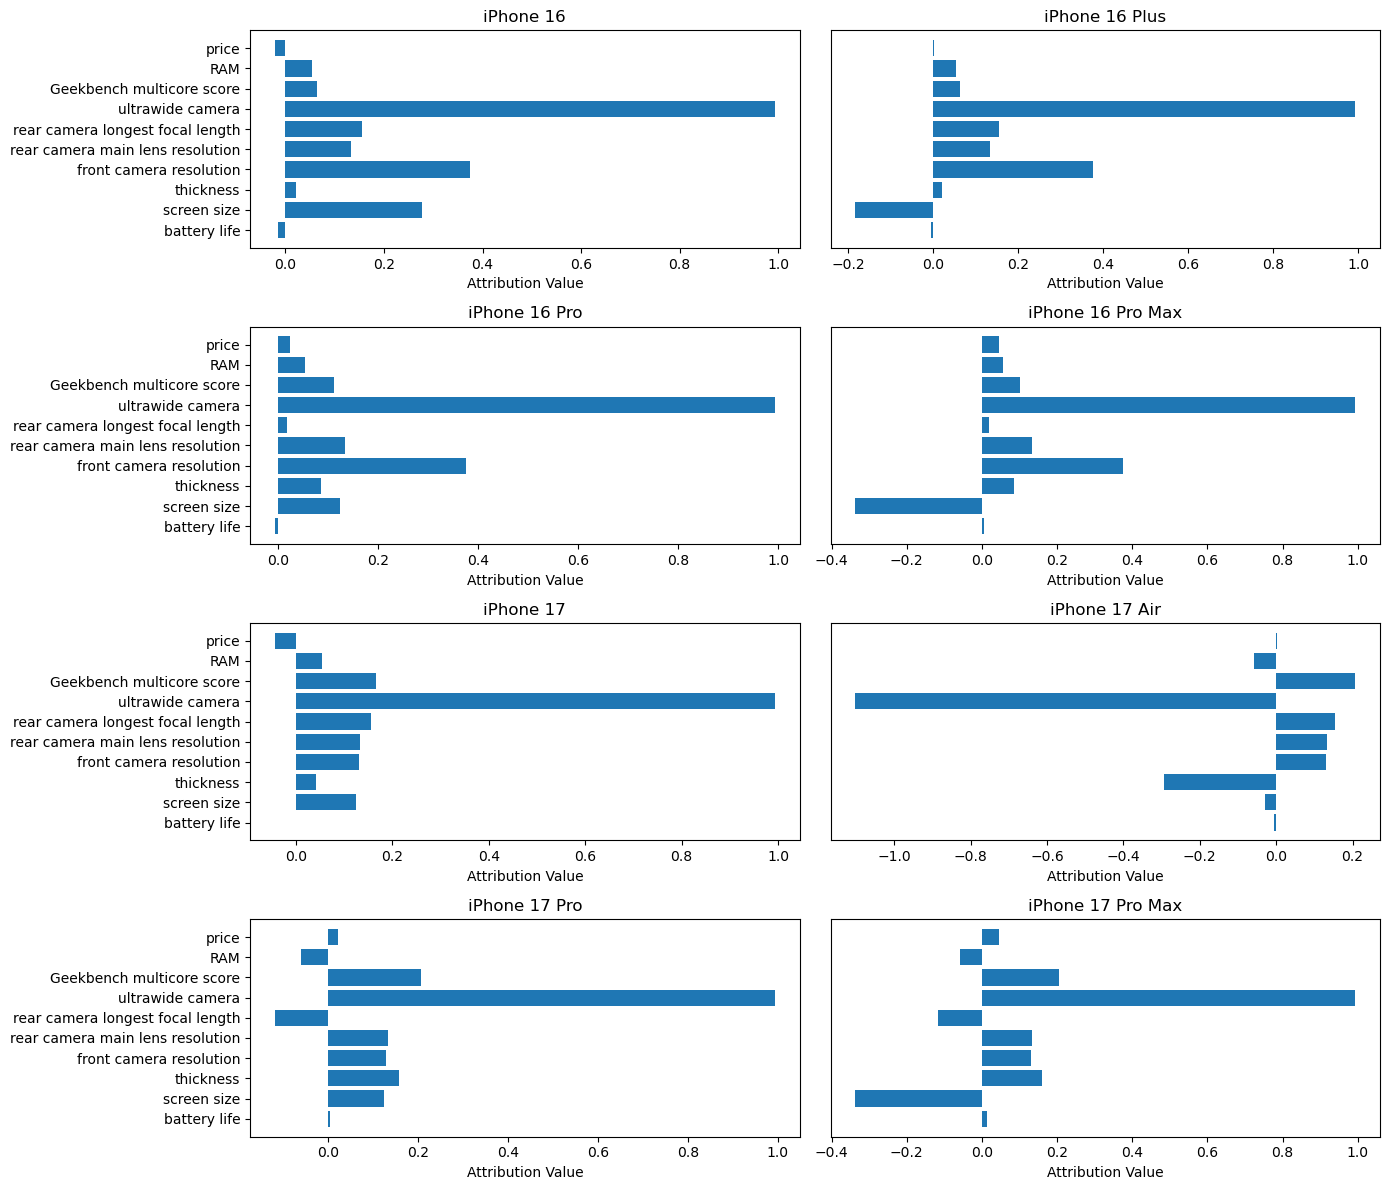

In [14]:
x_mean_single = X_val.mean(dim=0)
individual_IG_real_profiles(model_lr, real_profiles, x_mean_single=x_mean_single)

# Adp Lasso

In [10]:
# ==== 4) train model, and calibration ====
model_adalasso = LinearInteractionModel(
    in_dim=d,
    include_interaction=True,   # 是否加入交互项
    poly_degree=2,       # 多项式的最高次数
)

# 2) 训练：两阶段 Adaptive Lasso + 自动选 λ（不改你原来的训练/打分代码）
model_adalasso, info = train_pairwise_adalasso(
    model_adalasso,
    train_loader=dl_tr,
    valid_loader=dl_va,
    lr=2e-3,
    weight_decay=0.0,
    warmup_epochs=5,
    finetune_epochs=20,
    patience=3,
    gamma=1.0,
    eps=1e-4,
    # lambda_grid=[1e-3, 3e-3, 1e-2, 3e-2, 1e-1],          # large penalty grid set
    lambda_grid=None,  # 自动选 λ 
    lambda_scale=1.0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# 3) （可选）温度标定 & 排序/概率
T = calibrate_temperature(model_adalasso, dl_va)


== Warmup without L1 ==
[Epoch 01] train_loss=0.6113  val_loss=0.5557
[Epoch 02] train_loss=0.5003  val_loss=0.4893
[Epoch 03] train_loss=0.4503  val_loss=0.4526
[Epoch 04] train_loss=0.4208  val_loss=0.4299
[Epoch 05] train_loss=0.4025  val_loss=0.4157
== Try lambda=1.00e-05 ==
   [λ=1.00e-05 ep=01] train=0.3879  val=0.4004  *
   [λ=1.00e-05 ep=02] train=0.3767  val=0.3933  *
   [λ=1.00e-05 ep=03] train=0.3718  val=0.3911  *
   [λ=1.00e-05 ep=04] train=0.3696  val=0.3909  *
   [λ=1.00e-05 ep=05] train=0.3685  val=0.3905  *
   [λ=1.00e-05 ep=06] train=0.3678  val=0.3897  *
   [λ=1.00e-05 ep=07] train=0.3675  val=0.3897  *
   [λ=1.00e-05 ep=08] train=0.3674  val=0.3897
   [λ=1.00e-05 ep=09] train=0.3678  val=0.3896  *
   [λ=1.00e-05 ep=10] train=0.3671  val=0.3903
   [λ=1.00e-05 ep=11] train=0.3675  val=0.3903
   [λ=1.00e-05 ep=12] train=0.3674  val=0.3895  *
   [λ=1.00e-05 ep=13] train=0.3675  val=0.3901
   [λ=1.00e-05 ep=14] train=0.3674  val=0.3906
   [λ=1.00e-05 ep=15] train=0.3673 

Attribution shape: torch.Size([8, 10])


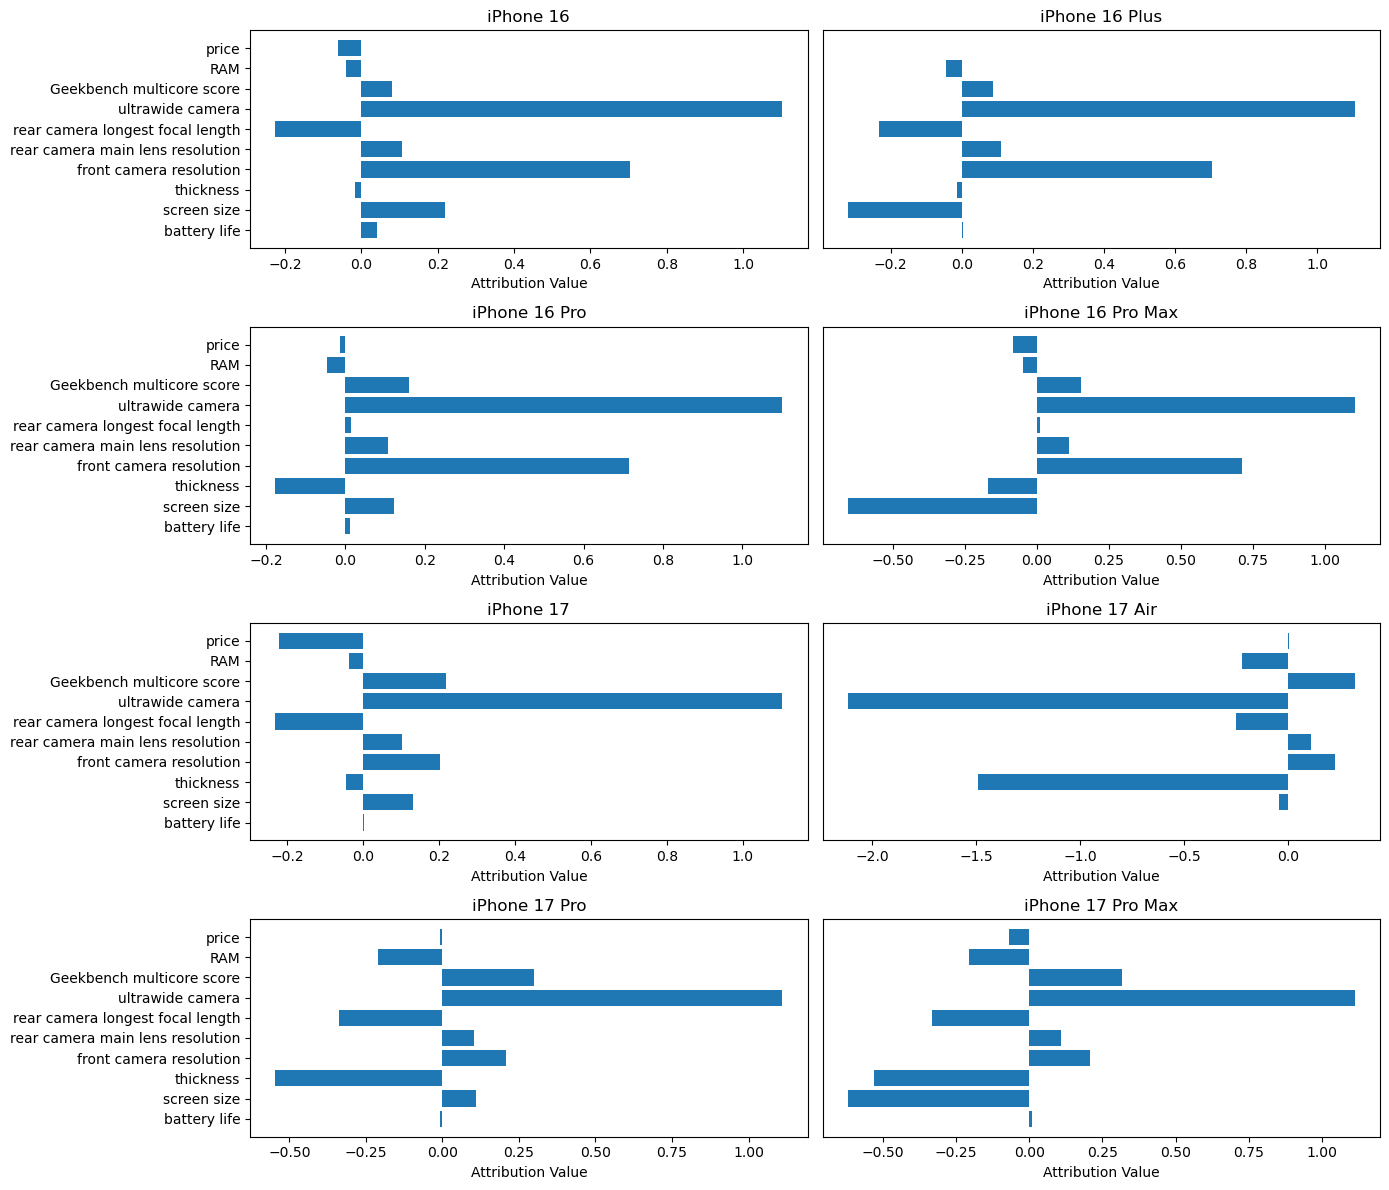

In [11]:
x_mean_single = X_val.mean(dim=0)
individual_IG_real_profiles(model_adalasso, real_profiles, x_mean_single=x_mean_single)

# cross partial (compare among three models)

In [35]:
from torch.autograd.functional import hessian

def cross_partial_model_compare(models, df):
    X_df = preprocess_test(df.iloc[:,:10])
    feature_names = [i.split(" (")[0] for i in df.columns.tolist()[:10]]

    fig, axes = plt.subplots(len(df), len(models), figsize=(5*len(models), 3*len(df)))
    for i in range(len(df)):  
        for j, model in enumerate(models):
            def f_wrapped(x1d):
                # x1d: (10,)  -> 模型期望 (1, 10)
                out = model(x1d.unsqueeze(0))  # (1, 1) 或 (1,)
                return out.view(-1)[0]         # 标量
            x = X_df[i].view(1, 10).to(next(model.parameters()).device)
            x = x.clone().detach().requires_grad_(True)
            H = hessian(f_wrapped, x.squeeze(0))   # 形状 (10, 10)
            # 数值对称化（更稳）
            H = (H + H.T) / 2
            H_plot = H.detach().cpu().numpy()  # 或者单样本 H
            im = axes[i,j].imshow(H_plot, cmap='bwr', vmin=-7, vmax=7, aspect='auto')  # 红正蓝负
            if model.__class__.__name__ == "LinearInteractionModel":
                axes[i,j].set_title(f"InterSqrLasso - {df.index[i]}")
            else:
                axes[i,j].set_title(f"{model.__class__.__name__} - {df.index[i]}")
            if j == 0:
                axes[i,j].set_yticks(range(len(feature_names)))
                axes[i,j].set_yticklabels(feature_names)
            if i == (len(df)-1):
                axes[i,j].set_xticks(range(len(feature_names)))
                axes[i,j].set_xticklabels(feature_names, rotation=60, ha='right')
            fig.colorbar(im, ax=axes[i,j])
    plt.tight_layout()
    plt.savefig(f"../plot/Cross_Profile_Comparison.png")
    plt.show()


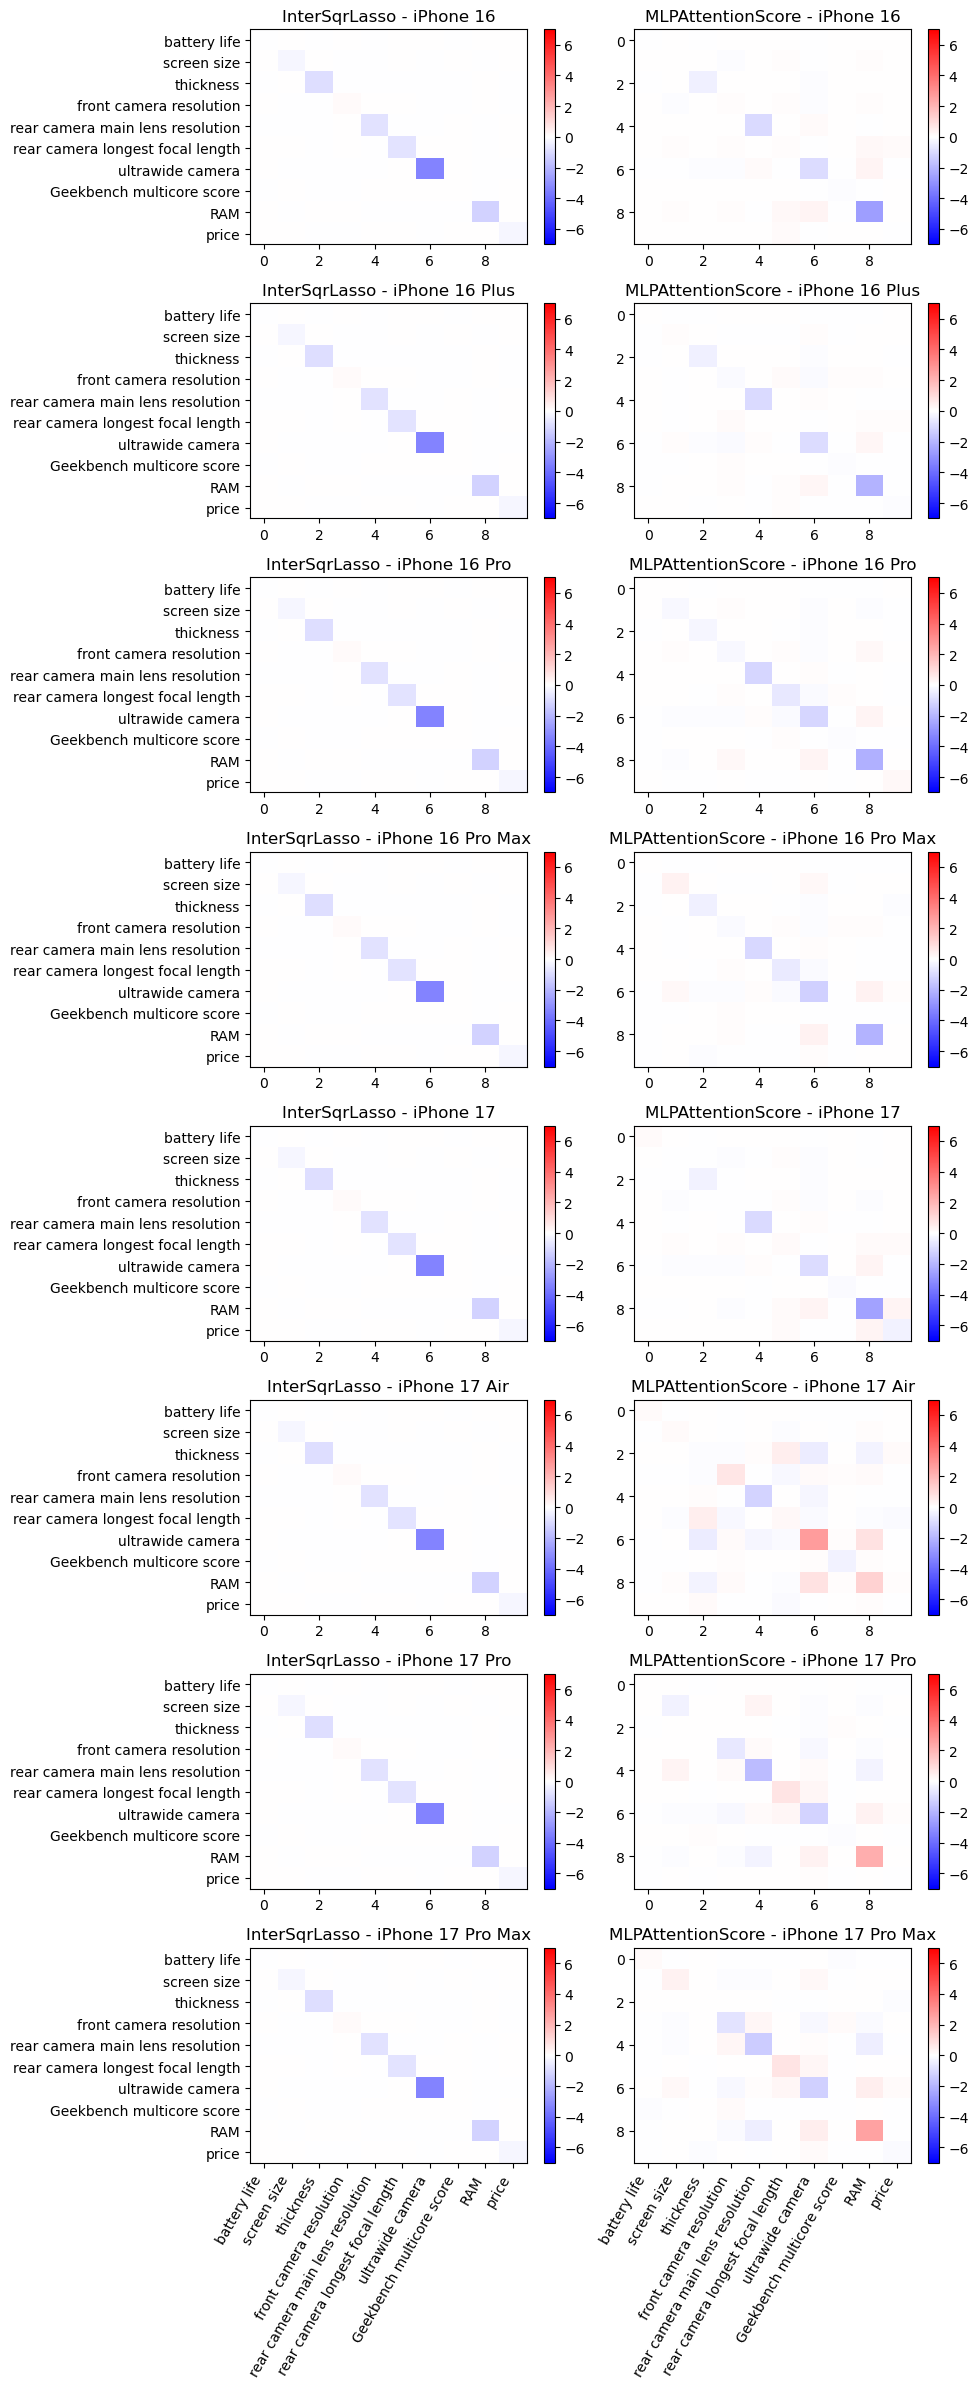

In [36]:
cross_partial_model_compare([model_adalasso, model_att], real_profiles)